# Thermal sensitivity of consumption

### Table of Contents

* [1. Definition](#def)
* [2. Functions estimate  thermosensitivity and decompose consumption](#2functions)
* [3. Functions plays with thermosensitivity of consumption and resimulate](#3functionsII)

In this notebook, you will manipulate some temperature time series,
together with models of the thermal sensitivity of consumption. In the end you will learn how to:
* estimate thermal sensitivity give time series of consumption and temperature
* decompose a consumption into two parts. The first one will not be correlated with temperature and the other one will depend linearly of cold temperatures
* remove the effect of temperature from year "x" in a consumption time series and apply the temperature from year "y".
* use a thermal sensitive consumption model to model electric car consumption


In [7]:
import os
os.chdir('..') ## to work at project root  like in any IDE


import numpy as np
import pandas as pd
import csv
import datetime
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import linear_model

#os.chdir('D:\GIT\Etude_TP_CapaExpPlaning-Python')
from functions.functions_decompose_thermosensibilite import * #Il faut préciser le chemin où vous avez sauvegardé les données csv
from functions.functions_GraphicalTools import * #Il faut préciser le chemin où vous avez sauvegardé les données csv
#data=pd.read_csv('CSV/input/ConsumptionTemperature_1996TO2019_FR.csv')

ConsoTempe_df=pd.read_csv('CSV/input/ConsumptionTemperature_1996TO2019_FR.csv')

SyntaxError: non-default argument follows default argument (functions_GraphicalTools.py, line 56)

## 1. Definition <a class="anchor" id="def"></a>
As an introduction, french speakers can read [my post](https://www.energy-alternatives.eu/2019/05/24/variabilite-de-la-consommation-electrique-et-thermo-sensibilite.html) (contribution for translation of this site's posts are welcome) on the subject.

You can observe how consumption depends upon temperature for year 2012.
Below a threshold temperature, here around 15 degres,
the relation between consumption and temperature is linear.
The coefficient of the linear regression is,
by definition, what we call the thermal sensitivity.

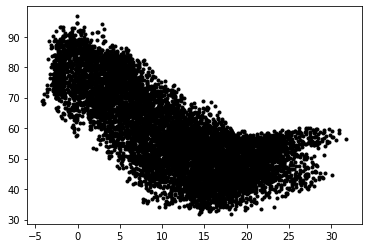

-2242.5311684188764

In [3]:
year = 2010
hour = 19
TemperatureThreshold = 15

ConsoTempeYear_df=ConsoTempe_df[pd.to_datetime(ConsoTempe_df['Date']).dt.year==year]
plt.plot(ConsoTempeYear_df['Temperature'],ConsoTempeYear_df['Consumption']/1000, '.', color='black');
plt.show()
## select dates to do the linear regression
indexHeatingHour = (ConsoTempeYear_df['Temperature'] <= TemperatureThreshold) &\
                    (pd.to_datetime(ConsoTempeYear_df['Date']).dt.hour == hour)
ConsoHeatingHour= ConsoTempeYear_df[indexHeatingHour]
lr=linear_model.LinearRegression().fit(ConsoHeatingHour[['Temperature']],
                                       ConsoHeatingHour['Consumption'])
lr.coef_[0]

## 2. Functions estimate  thermosensitivity and decompose consumption <a class="anchor" id="2functions"></a>

Formally, the preceding linear regression is given by the following formula:

$$ C_t = C^{NT}_t+\rho_{h(t)}(T_t-T_0)_+$$

where $T_0$ is the threshold temperature, $(x)_+$ is $x$ for any non negative $x$ and zero otherwise,
$\rho_{h(t)}$ is the thermal sensitivity for hour $h$ (if it depends upon the hour of the day)
$C^{NT}_t$ is the part of the consumption that is not sensitive to the temperature.
It is obtained as the residuals of the linear regression for temperatures
lower than $T_0$ and is the consumption itself otherwise.

In module functions.functions_decompose_thermosensibilite, we have implemented
a function to estimate the different elements in the preceding equation, given consumption, temperature and other parameters (such as $T_0$).
Check the file functions_decompose_thermosensibilite.py to understand how this works.

In [6]:
(ConsoTempeYear_decomposed_df,Thermosensibilite)=Decomposeconso(ConsoTempeYear_df,TemperatureThreshold=TemperatureThreshold)
fig=MyStackedPlotly(x_df=ConsoTempeYear_decomposed_df['Date'],
                    y_df=ConsoTempeYear_decomposed_df[["NTS_C","TS_C"]],
                    Names=['Conso non thermosensible','conso thermosensible'])
fig.update_layout(title_text="Consommation (MWh)", xaxis_title="Date")
# plotly.offline.plot(fig, filename='file.html') ## offline
fig.show()

NameError: name 'MyStackedPlotly' is not defined

Q.1) Is the thermosensitivity coherent (value for day/night, min/max value) ?

Q.2) Compute the mean of thermosensitivity and compare it to the value you can find in [my post](https://www.energy-alternatives.eu/2019/05/24/variabilite-de-la-consommation-electrique-et-thermo-sensibilite.html).

## 3. Functions plays with thermosensitivity of consumption and resimulate <a class="anchor" id="3functionsII"></a>

You can do other interesting things. For example, you can redecompose the electric consumption of the year X to thermosensitive and no-thermosensitive parts from the thermosensitivity of the year X and the temperatures of the year Y. It's very useful to compare the years.

In [ ]:
## example for year 2012
newyear=2012
NewConsoTempeYear_df = ConsoTempe_df[pd.to_datetime(ConsoTempe_df['Date']).dt.year==newyear]
NewConsoTempeYear_decomposed_df=ChangeTemperature(ConsoTempeYear_decomposed_df,NewConsoTempeYear_df,Thermosensibilite, TemperatureThreshold=TemperatureThreshold)


### loop over years

fig = go.Figure()
fig.add_trace(go.Scatter(x=ConsoTempeYear_decomposed_df['Date'],y=ConsoTempeYear_decomposed_df['Consumption'],line=dict(color="#000000"),name="original"))
for newyear in range(2000,2012):
    NewConsoTempeYear_df = ConsoTempe_df[pd.to_datetime(ConsoTempe_df['Date']).dt.year==newyear]
    ConsoSepareeNew_df=Recompose(ConsoTempeYear_decomposed_df,Thermosensibilite,NewConsoTempeYear_df, TemperatureThreshold=TemperatureThreshold)
    fig.add_trace(go.Scatter(x=ConsoSepareeNew_df['Date'],
                             y=ConsoSepareeNew_df['Consumption'],
                             line=dict(color="#9CA2A8",width=1),
                             name=newyear))
# plotly.offline.plot(fig, filename='file.html') ## offline
fig.show()

Q.3)Compare this table to the previous one and comment the differences

In addition, with the same function Recompose to that you can also redecompose the electric consumption of the year X to thermosensitive and no-thermosensitive parts from a new table of thermosensitivity.

In [ ]:
NewThermosensibilite={}
for key in Thermosensibilite:    NewThermosensibilite[key]=1/3 * Thermosensibilite[key]
NewConsoTempeYear_decomposed_df=Recompose(ConsoTempeYear_decomposed_df,NewThermosensibilite, TemperatureThreshold=TemperatureThreshold)
fig = go.Figure()
fig.add_trace(go.Scatter(x=ConsoTempeYear_decomposed_df['Date'],
                         y=ConsoTempeYear_decomposed_df['Consumption'],
                         line=dict(color="#000000"),name="original"))
fig.add_trace(go.Scatter(x=NewConsoTempeYear_decomposed_df['Date'],
                             y=NewConsoTempeYear_decomposed_df['Consumption'],
                             line=dict(color="#9CA2A8",width=1),
                             name=newyear))
# plotly.offline.plot(fig, filename='file.html') ## offline
fig.show()

Now, you know everything about thermosensitivity and you can use theses functions whenever you want in the TP to cast light on interesting values and draw smart conclusions :)